In [1]:
#pip install imbalanced-learn

In [2]:
#pip install xgboost

In [3]:
#pip install imbalanced-learn before running the code - used for balancing the set in the later [random forest] part of the code
# pip install xgboost before running the code - used for the xgboost model
#pip install codecs before running the code - used for file import to dataframe

In [4]:
%matplotlib inline
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.express as px
import codecs

Dataframe edit for visuals

In [8]:
with codecs.open("Resources/DataCoSupplyChainDataset_Original.csv", 'r', encoding='ISO-8859-1') as f:
    DataCO_df = pd.read_csv(f)


DataCO_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Resources/DataCoSupplyChainDataset_Original.csv'

In [ ]:
#drop non-beneficial columns

co_data = DataCO_df.copy()
FeatureList = ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment',
       'Customer State', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name', 'Product Price',
       'shipping date (DateOrders)', 'Shipping Mode']
df_a = DataCO_df[FeatureList]
df_a.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Profit Per Order,Order Region,Order State,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,73,Smart watch,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,-249.089996,South Asia,Rajastán,PENDING,1360,73,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,-247.779999,South Asia,Rajastán,CLOSED,1360,73,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,22.860001,Oceania,Queensland,COMPLETE,1360,73,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,73,Smart watch,327.75,1/15/2018 11:24,Standard Class


## Visuals from initial data exploration

In [ ]:
#Category Name Visual
data_Category_Name=df_a.groupby(['Category Name'])['Order Id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= True)
px.bar(data_Category_Name, x='Number of Orders',y = 'Category Name',color ='Number of Orders')


In [ ]:
#Type of Payment Visual
df_payment_type=df_a.groupby([ 'Type'])['Sales'].sum().reset_index(name='Sales of Orders').sort_values(by= 'Sales of Orders', ascending= False)
px.bar(df_payment_type.head(10), x='Sales of Orders',y = 'Type',color ='Sales of Orders')

In [ ]:
#Customer Segments Visual
data_Customer_Segment=df_a.groupby(['Customer Segment'])['Order Id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
px.pie(data_Customer_Segment, values='Number of Orders', names= 'Customer Segment' , title= 'Number of Orders of different Customer Segments', 
       width=600 , height=600 , color_discrete_sequence = px.colors.sequential.RdBu)


## Linear Regression: Sales Prediction based on Order Volume

In [9]:
#read csv file to dataframe
sales_df = pd.read_csv("../Project-4/Resources/sales_df_VL.csv")
sales_df.head(5)

,order_date_VL,sales_per_day_VL,order_volume_VL,profit_per_day_VL,month_year_VL,item_qty_per_day_VL,avg_discount_per_day_VL,avg_product_price_per_day_VL
0,2015-01-01,28958.730381,57,4361.270029,2015-01,353,0.114880,136.668859
1,2015-01-02,25948.820225,52,1162.729983,2015-01,341,0.099664,124.169533
2,2015-01-03,32859.300341,60,5366.600017,2015-01,392,0.092402,136.982406
3,2015-01-04,31869.500330,62,5630.989989,2015-01,410,0.104241,123.622673
4,2015-01-05,27533.050215,57,3088.100046,2015-01,373,0.113875,121.256816


In [10]:
X = sales_df[['order_volume_VL','item_qty_per_day_VL','avg_discount_per_day_VL','avg_product_price_per_day_VL']]
y = sales_df["sales_per_day_VL"].values.reshape(-1, 1)

In [11]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [12]:
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

R-squared: 0.9452063923653357
RMSE: 712.0717319595923
MAE: 550.7522186313081


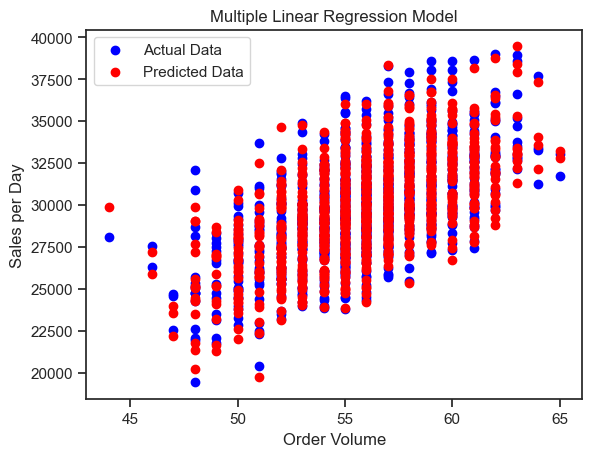

In [13]:
#plot the actual data versus the predicted data
plt.scatter(X['order_volume_VL'], y, color='blue', label='Actual Data')
plt.scatter(X['order_volume_VL'], y_pred, color='red', label='Predicted Data')
plt.xlabel('Order Volume')
plt.ylabel('Sales per Day')
plt.legend()
plt.title('Multiple Linear Regression Model')
plt.show()

## Supervised Learning: Late Delivery Risk Classification

Dataframe edit for Delivery Risk Classification

In [14]:
# Dropping irrelevant columns
cols_to_drop = [
    'Customer Email',
    'Customer Fname',
    'Customer Id',
    'Customer Lname',
    'Customer Password',
    'Order Id',
    'Order Item Cardprod Id',
    'Product Card Id',
    'Product Category Id',
    'Product Description',
    'Product Image',
    'Product Name',
    'Product Status',
    'Order Zipcode',
    'shipping date (DateOrders)', 
    'Delivery Status',
    'Days for shipping (real)'
    ]
df_c = DataCO_df.drop(cols_to_drop, axis=1)
df_c.head()

NameError: name 'DataCO_df' is not defined

In [ ]:
# Handle missing values
df_c['Customer Zipcode'].fillna(0, inplace=True)  # Replace missing zipcodes with 0

In [ ]:
# Encode categorical variables
label_encoders = {}
categorical_cols = df_c.select_dtypes(include=['object']).columns
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_c[col] = label_encoders[col].fit_transform(df_c[col])

In [ ]:
# Define features (X) and target (y)
X = df_c.drop('Late_delivery_risk', axis=1)
y = df_c['Late_delivery_risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Key: (0) = Not Late, (1) = Late")
print(f"-----------------------------")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Key: (0) = Not Late, (1) = Late
-----------------------------
Accuracy: 0.8556392643474408
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85     16307
           1       0.93      0.80      0.86     19797

    accuracy                           0.86     36104
   macro avg       0.86      0.86      0.86     36104
weighted avg       0.87      0.86      0.86     36104



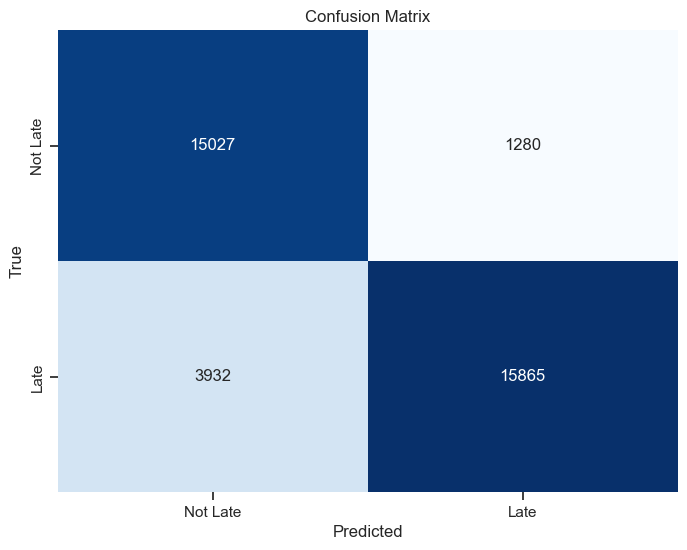

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

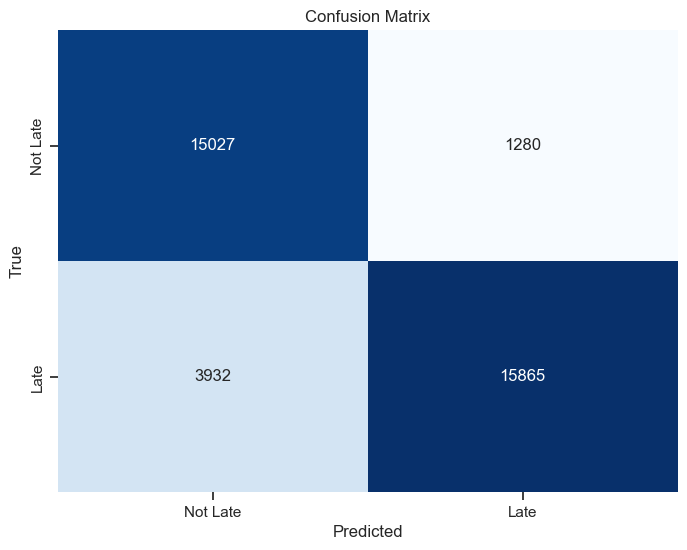

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Late', 'Late'], yticklabels=['Not Late', 'Late'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression: Fraudulent Orders Prediction

Unique order dataframe preparation

In [16]:
#read csv file into dataframe orders_df from Resources folder
file_path = Path("Resources/orders_df.csv")
orders_df = pd.read_csv(file_path)

In [19]:
#dummy code categorical columns
orders_df = pd.get_dummies(orders_df, columns=["Type", "Customer Segment", "Order Country", "Order State", "Shipping Mode", "Market", "Order Region"])
orders_df.head()

,Order Id,Days for shipment (scheduled),order_original_price,order_discount,no_of_items,order_total,no_of_unique_items,no_of_unique_categories,no_of_unique_departments,fraud,...,Order Region_South Asia,Order Region_South of USA,Order Region_Southeast Asia,Order Region_Southern Africa,Order Region_Southern Europe,Order Region_US Center,Order Region_West Africa,Order Region_West Asia,Order Region_West of USA,Order Region_Western Europe
0,1,4,299.980011,60.000000,1,239.979996,1,1,1,0,...,False,False,False,False,False,False,False,False,False,False
1,2,4,379.980011,50.600000,7,529.380005,3,3,3,0,...,False,False,False,False,False,False,False,False,False,False
2,4,4,184.960001,78.980000,14,620.870014,4,4,4,0,...,False,False,False,False,False,False,False,False,False,False
3,5,4,839.920029,142.789999,10,987.070007,4,4,2,0,...,False,False,False,False,False,False,False,False,False,False
4,7,2,515.960016,54.400000,7,525.520004,3,3,2,0,...,False,False,False,False,False,False,False,False,False,False


In [20]:
#show row count
orders_df.count()

Order Id                         64385
Days for shipment (scheduled)    64385
order_original_price             64385
order_discount                   64385
no_of_items                      64385
                                 ...  
Order Region_US Center           64385
Order Region_West Africa         64385
Order Region_West Asia           64385
Order Region_West of USA         64385
Order Region_Western Europe      64385
Length: 1301, dtype: int64

In [21]:
# Define features set 
X = orders_df.copy()
X.drop('fraud', axis=1, inplace=True)
X.head()

,Order Id,Days for shipment (scheduled),order_original_price,order_discount,no_of_items,order_total,no_of_unique_items,no_of_unique_categories,no_of_unique_departments,Type_CASH,...,Order Region_South Asia,Order Region_South of USA,Order Region_Southeast Asia,Order Region_Southern Africa,Order Region_Southern Europe,Order Region_US Center,Order Region_West Africa,Order Region_West Asia,Order Region_West of USA,Order Region_Western Europe
0,1,4,299.980011,60.000000,1,239.979996,1,1,1,True,...,False,False,False,False,False,False,False,False,False,False
1,2,4,379.980011,50.600000,7,529.380005,3,3,3,False,...,False,False,False,False,False,False,False,False,False,False
2,4,4,184.960001,78.980000,14,620.870014,4,4,4,True,...,False,False,False,False,False,False,False,False,False,False
3,5,4,839.920029,142.789999,10,987.070007,4,4,2,False,...,False,False,False,False,False,False,False,False,False,False
4,7,2,515.960016,54.400000,7,525.520004,3,3,2,False,...,False,False,False,False,False,False,False,False,False,False


TESTING RANDOM FOREST MODEL

In [22]:
# Define target vector
y = orders_df["fraud"].values.reshape(-1, 1)
y[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [23]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [24]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [25]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [26]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [27]:
X_train.shape

(48288, 1300)

In [28]:
X_test.shape

(16097, 1300)

In [29]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [30]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

In [31]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [32]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [33]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Legitemate [0],Fraud [1]
Legitemate [0],15744,14
Fraud [1],337,2


Accuracy Score : 0.9781946946636019
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15758
           1       0.12      0.01      0.01       339

    accuracy                           0.98     16097
   macro avg       0.55      0.50      0.50     16097
weighted avg       0.96      0.98      0.97     16097



In [34]:
# Get the feature importance array
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted

[(0.10559104525988358, 'Order Id'),
 (0.10326769339948677, 'order_total'),
 (0.10189887764580227, 'order_discount'),
 (0.09194044218462787, 'order_original_price'),
 (0.0637877711734773, 'no_of_items'),
 (0.044587434378726754, 'Type_TRANSFER'),
 (0.027703465610448327, 'no_of_unique_departments'),
 (0.02713622132153613, 'no_of_unique_categories'),
 (0.026936107209012575, 'no_of_unique_items'),
 (0.020078362189909205, 'Days for shipment (scheduled)'),
 (0.01904276367169809, 'Customer Segment_Consumer'),
 (0.016772682919352907, 'Customer Segment_Corporate'),
 (0.014423972598663206, 'Type_DEBIT'),
 (0.013613023241952904, 'Customer Segment_Home Office'),
 (0.013530038449195604, 'Shipping Mode_Standard Class'),
 (0.010975820676397326, 'Shipping Mode_Second Class'),
 (0.00995240442501146, 'Shipping Mode_First Class'),
 (0.009082075308725492, 'Type_PAYMENT'),
 (0.004821985463355956, 'Shipping Mode_Same Day'),
 (0.004281506562662031, 'Type_CASH'),
 (0.0019802692959401333, 'Order State_Languedoc

Despite high accuracy, the recall for fraud cases is ridiculously low - A recall of 0.01 for fraud means the model is missing out on 99% of actual fraud cases, which is a significant risk in a real-world scenario. Assuming that data imbalance is the most likely issue, adding a resampling strategy to improve the recall

In [35]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [36]:
# Rebalance the dataset
# Use SMOTE to oversample the minority class and RandomUnderSampler to undersample the majority class
resampling = Pipeline([('SMOTE', SMOTE()), ('RandomUnderSampler', RandomUnderSampler())])
X_train_balanced, y_train_balanced = resampling.fit_resample(X_train_scaled, y_train)

In [37]:
# Create the random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)
rf_model = rf_model.fit(X_train_balanced, y_train_balanced)

In [38]:
# Predict
predictions = rf_model.predict(X_test_scaled)

In [39]:
# Evaluations
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)
acc_score = accuracy_score(y_test, predictions)


In [51]:
print(np.unique(y_test))
print(np.unique(predictions))

[0 1]
[0 1]


In [40]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Legitemate [0],Fraud [1]
Legitemate [0],15677,81
Fraud [1],330,9


Accuracy Score : 0.9744672920419954
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15758
           1       0.10      0.03      0.04       339

    accuracy                           0.97     16097
   macro avg       0.54      0.51      0.51     16097
weighted avg       0.96      0.97      0.97     16097



Testing balanced model approach to improve fraud detection

In [41]:
# Use class_weight='balanced' for cost-sensitive training
rf_model = RandomForestClassifier(n_estimators=500, random_state=78, class_weight='balanced')
rf_model = rf_model.fit(X_train_balanced, y_train_balanced)

In [42]:
# Predict probabilities
probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]


In [43]:
# Adjust the decision threshold to increase recall
threshold = 0.3
predictions = np.where(probabilities > threshold, 1, 0)

In [44]:
# Evaluations
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)
acc_score = accuracy_score(y_test, predictions)

# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Legitemate [0],Fraud [1]
Legitemate [0],15444,314
Fraud [1],313,26


Accuracy Score : 0.961048642604212
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15758
           1       0.08      0.08      0.08       339

    accuracy                           0.96     16097
   macro avg       0.53      0.53      0.53     16097
weighted avg       0.96      0.96      0.96     16097



Increased a recall at cost of accuracy - dismall results - attempting to improve the model with XBoost to further improve fraud detection recall

In [45]:
import xgboost as xgb

In [46]:
# Convert the dataset into an optimized data structure that XGBoost supports
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

In [47]:
scale_pos_weight_val = float((y_train == 0).sum() / (y_train == 1).sum())

In [48]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'scale_pos_weight': scale_pos_weight_val,  # corrected this line
    'eta': 0.1
}

In [49]:
# Train the model
num_rounds = 300
bst = xgb.train(params, dtrain, num_rounds)

# Predict probabilities
probabilities = bst.predict(dtest)
predictions = [1 if prob > 0.5 else 0 for prob in probabilities]

# Evaluation
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Legitemate [0]", "Fraud [1]"], columns=["Legitemate [0]", "Fraud [1]"]
)
acc_score = accuracy_score(y_test, predictions)

In [50]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Legitemate [0],Fraud [1]
Legitemate [0],12616,3142
Fraud [1],61,278


Accuracy Score : 0.8010188233832392
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     15758
           1       0.08      0.82      0.15       339

    accuracy                           0.80     16097
   macro avg       0.54      0.81      0.52     16097
weighted avg       0.98      0.80      0.87     16097



Classification Report:

Class 0 (Legitimate Transactions):

Precision: 1.00 (When the model predicted a transaction was legitimate, it was correct 100% of the time.) Recall: 0.80 (The model correctly identified 80% of all legitimate transactions.) F1-Score: 0.89 (The harmonic mean of precision and recall, giving a balanced measure for this class.) Class 1 (Fraudulent Transactions):

Precision: 0.08 (When the model predicted a transaction was fraudulent, it was correct only 8% of the time.) Recall: 0.84 (The model correctly identified 84% of all fraudulent transactions, which is a good recall rate for fraud detection. However, this came at the cost of having many false positives.) F1-Score: 0.15 (Given the low precision and high recall, the F1-score for this class is low, indicating a potential area of improvement.)

Interpretation: The model seems to be taking a conservative approach to fraud detection. While it has done a commendable job in identifying 84% of the fraudulent transactions (recall for Class 1), this high recall rate for fraudulent transactions has come at the expense of a large number of false positives (3,146 legitimate transactions incorrectly flagged as fraudulent). This is reflected in the very low precision (0.08) for Class 1.

Such a model could be problematic in real-world scenarios, especially if there are high costs or inconveniences associated with falsely flagging a transaction as fraudulent.